In [ ]:
# Installing my implementation  of VGGFace 
!pip install git+https://github.com/IronOnet/keras-vggface.git

  Cloning https://github.com/IronOnet/keras-vggface.git to /tmp/pip-req-build-i337l9kk
  Running command git clone -q https://github.com/IronOnet/keras-vggface.git /tmp/pip-req-build-i337l9kk
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8313 sha256=67eb647cf21892e1733c055db5fbc78751448425c3c517ef73d16aad48d64205
  Stored in directory: /tmp/pip-ephem-wheel-cache-dykjkfe_/wheels/6f/e6/62/cf3ea910e2020d0784d1a33d01e4e7a1e53a2937656d33d2f4
Successfully built keras-vggface


In [ ]:
!pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pillow, scipy, keras, numpy, six, h5py, pyyaml
Required-by: 


In [ ]:
import keras_vggface 
print(keras_vggface.__version__)

0.6


In [ ]:
# MTCNN (Multi Task Cascaded Convolutional neural network) 
# this model is a state of the art in face detection (finding and extracting) 
# faces from photos 
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 32.1 MB/s 


In [ ]:
# Utilities for loading images 
import urllib.request 

def store_image(url, local_file_name): 
  with urllib.request.urlopen(url) as resource: 
    with open(local_file_name, 'wb') as f: 
      f.write(resource.read()) 

store_image('https://upload.wikimedia.org/wikipedia/commons/1/1d/Colonel_Mobutu.jpg', 'mobutu_1.jpg')

In [ ]:
import matplotlib.pyplot as plt  

pixels = plt.imread('mobutu_1.jpg')

In [ ]:
from mtcnn import MTCNN

detector = MTCNN() 
# detect faces in the image 
results = detector.detect_faces(pixels)

In [ ]:
results

[{'box': [282, 129, 240, 294],
  'confidence': 0.9999914169311523,
  'keypoints': {'left_eye': (391, 230),
   'mouth_left': (388, 347),
   'mouth_right': (478, 359),
   'nose': (461, 288),
   'right_eye': (492, 240)}}]

In [ ]:
# Extract the bounding box from the first face 
x1, y1, width, height = results[0]['box'] 
x2, y2 = x1 + width, y1 + height

In [ ]:
# Extract the face 
face = pixels[y1:y2, x1:x2]

In [ ]:
import numpy as np
from PIL import Image

# Extract a single face from a given image 
def extract_face(filename, required_size=(224, 224)): 
  # load image from file 
  pixels = plt.imread(filename) 
  # create the detector, using default weights 
  detector = MTCNN() 
  # detect faces in the image
  results = detector.detect_faces(pixels) 
  # extract the bounding box from the first face 
  x1, y1, width, height = results[0]['box'] 
  x2, y2 = x1 + width, y1 + height 
  x2, y2 = x1 + width, y1 + height 

  # extract the face 
  face = pixels[y1:y2, x1:x2] 
  # resize pixels to the mode size 
  image = Image.fromarray(face) 
  image = image.resize(required_size) 
  face_array = np.asarray(image)
  return face_array

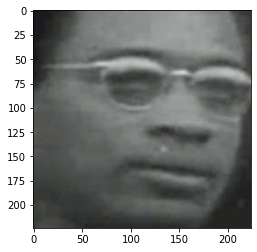

In [ ]:
pixels = extract_face('mobutu_1.jpg') 
plt.imshow(pixels) 
plt.show()

In [ ]:
# Creating a face embedding 
from keras_vggface.vggface import VGGFace 

model = VGGFace(model='resnet50') 
# summarize the model inputs and outpu shape
print('Inputs: %s' % model.inputs) 
print('Outputs: %s' % model.outputs)

165453824/165439116 [==============================] - 1s 0us/step
Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_16')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [ ]:
from keras_vggface.utils import preprocess_input 
from keras_vggface.utils import decode_predictions

pixels = extract_face('mobutu_1.jpg') 
pixels = pixels.astype('float32') 
samples = np.expand_dims(pixels, axis=0) 
samples = preprocess_input(samples, version=2) 
# create a vggface model 
model = VGGFace(model='resnet50') 
# perform predictions 
y_hat = model.predict(samples) 
results = decode_predictions(y_hat)  
for result in results[0]: 
  print('%s: %.3f' % (result[0], result[1]*100))

1359872/1346516 [==============================] - 0s 0us/step
b' Moussa_Dadis_Camara': 11.197
b' Katon_W._De_Pena': 9.074
b' Seu_Jorge': 6.549
b' Rauf_Aregbesola': 3.861
b' Michel_Kafando': 3.250


In [ ]:
from scipy.spatial.distance import cosine

# Face verification 
def get_embeddings(filenames): 
  # extract faces 
  faces = [extract_face(f) for f in filenames] 
  # convert into an array of samples 
  samples = np.asarray(faces, 'float32') 
  # prepare the face for the model, e.g center pixels 
  samples = preprocess_input(samples, version=2) 
  # create a vggface model 
  model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

  # peform prediction 
  yhat = model.predict(samples) 
  return yhat 

# deternmine if a candidate face is a match for a known face 
def is_match(known_embedding, candidate_embedding, thresh=0.5): 
  # calculate distance between ebmeddings 
  score = cosine(known_embedding, candidate_embedding) 
  if score <= thresh: 
    print('> Face is a match (%.3f <= %.3f)' % (score, thresh)) 

  else: 
    print('> Face is not a match (%.3f > %.3f)' % (score, thresh)) 

  

In [ ]:
store_image('https://upload.wikimedia.org/wikipedia/commons/3/3d/Mobutu.jpg', 'mobutu_2.jpg'); 
store_image('https://upload.wikimedia.org/wikipedia/commons/b/be/Joseph_kabila.jpg', 'joseph_kabila_1.jpg');
store_image('https://upload.wikimedia.org/wikipedia/commons/5/58/President_Kabila_voting_in_the_2018_general_elections.jpg','joseph_kabila_2.jpg');
filenames = ['mobutu_1.jpg', 'mobutu_2.jpg', 'joseph_kabila_1.jpg', 'joseph_kabila_2.jpg']

In [ ]:
embeddings = get_embeddings(filenames) 
# define mobutu 
mobutu_id = embeddings[0] 
# verify known photos of mobutu 
print('Positive Tests') 
is_match(embeddings[0], embeddings[1]) 

print('Negative Tests') 
is_match(embeddings[0], embeddings[2])

Positive Tests
> Face is a match (0.493 <= 0.500)
Negative Tests
> Face is not a match (0.733 > 0.500)


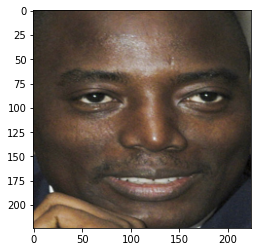

In [ ]:
pixels = extract_face('joseph_kabila_1.jpg') 
plt.imshow(pixels) 
plt.show()